In [2]:
from main import Unsupervised_FF, train, plot_loss
import torch, torchvision
from torch.utils.data import DataLoader
from torch.nn.functional import cosine_similarity
from utils import prepare_data

In [3]:
prepare_data()

# Load the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
# pos_dataset = Subset(pos_dataset, list(range(1000)))
# Create the data loader
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the transformed images
neg_dataset = torch.stack(torch.load('transformed_dataset.pt'))
# Create the data loader
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the test images
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
# Create the data loader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unsupervised_ff = Unsupervised_FF(device=device, n_epochs=10)

loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

Training Last Layer: 100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


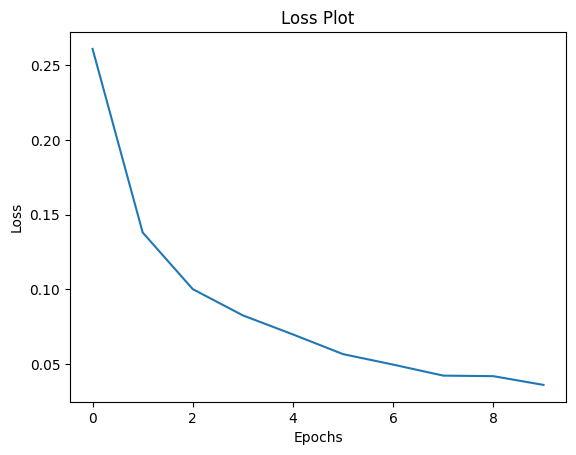

In [5]:
plot_loss(loss)

In [6]:
unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")

Train dataset scores:  accuracy_score: 0.9850166666666667


Test dataset scores:  accuracy_score: 0.9575


In [7]:
from tqdm import tqdm
inner_tqdm = tqdm(test_dataloader, desc=f"Evaluating model", leave=False, position=1)
all_encodings = []
for image, labels in inner_tqdm:
    image = image[0].to(unsupervised_ff.device)
    all_encodings.append(unsupervised_ff.encoding(image).detach().cpu())

all_encodings = torch.stack(all_encodings)


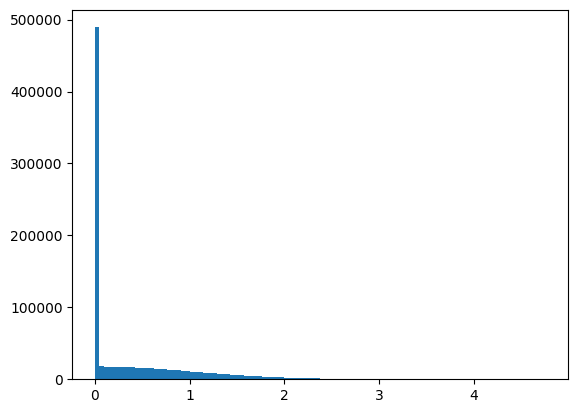

tensor(2108.7263)
torch.Size([1, 1, 6000])


In [8]:
from matplotlib import pyplot as plt
from traitlets import All   
plt.hist(all_encodings.flatten().numpy(), bins=100)
plt.show()
print(sum(all_encodings[0][all_encodings[0] > 0.5]))
print(all_encodings[0].shape)

In [9]:
def get_weights(model):
    weights = {}
    for idx, layer in enumerate(model.ff_layers):
        weights[f"layer_{idx}"] = layer.weight.data
    weights["last_layer"] = model.last_layer.weight.data
    return weights

In [10]:
print(get_weights(unsupervised_ff))

{'layer_0': tensor([[-0.0002,  0.0011,  0.0155,  ...,  0.0010,  0.0041, -0.0172],
        [-0.0009, -0.0259,  0.0257,  ..., -0.0279, -0.0030,  0.0250],
        [-0.0054, -0.0212,  0.0100,  ..., -0.0289,  0.0021,  0.0153],
        ...,
        [ 0.0174, -0.0249, -0.0085,  ..., -0.0216, -0.0354,  0.0221],
        [-0.0166, -0.0219,  0.0210,  ..., -0.0155, -0.0221, -0.0013],
        [ 0.0126,  0.0154, -0.0189,  ..., -0.0177, -0.0088, -0.0199]],
       device='cuda:0'), 'layer_1': tensor([[-0.0060,  0.0081,  0.0090,  ...,  0.0138,  0.0162, -0.0066],
        [-0.0221, -0.0040,  0.0027,  ...,  0.0134,  0.0062, -0.0052],
        [ 0.0046,  0.0182, -0.0213,  ...,  0.0133,  0.0166, -0.0173],
        ...,
        [ 0.0093,  0.0015,  0.0153,  ...,  0.0158,  0.0214,  0.0075],
        [ 0.0060, -0.0144, -0.0154,  ...,  0.0010, -0.0005, -0.0217],
        [ 0.0017, -0.0018, -0.0184,  ...,  0.0159, -0.0217, -0.0055]],
       device='cuda:0'), 'layer_2': tensor([[-2.0658e-02, -1.4298e-02, -2.0173e-03, 

In [25]:
def get_sparse_representation(model, image):
    encodings = model.encoding(image)
    return encodings.reshape(-1).detach()

In [26]:
import random
import numpy as np
from scipy.spatial.distance import hamming
sparse_representations = [[] for _ in range(10)]
for x_batch, y_batch in test_dataloader:
    for x, y in zip(x_batch, y_batch):
        sparse_representations[y.item()].append(get_sparse_representation(unsupervised_ff, x))

In [27]:
similarities_c = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            similarity_c = cosine_similarity(sparse_representations[i][j].unsqueeze(0), sparse_representations[i][k].unsqueeze(0))
            similarities_c[i].append(similarity_c.item())

In [28]:
similarities_h = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            binary_i_j = np.where(sparse_representations[i][j].cpu().numpy() > 0, 1, 0)
            binary_random_k = np.where(sparse_representations[i][k].cpu().numpy() > 0, 1, 0)
            similarity_h = hamming(binary_i_j, binary_random_k)
            similarities_h[i].append(similarity_h)

In [29]:
dissimilarities_c = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            while True:
                random_class = random.randint(0,9)
                if random_class != i:
                    break
            dissimilarity_c = cosine_similarity(sparse_representations[i][j].unsqueeze(0), sparse_representations[random_class][k].unsqueeze(0))
            dissimilarities_c[i].append(dissimilarity_c.item())

In [30]:
dissimilarities_h = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            while True:
                random_class = random.randint(0,9)
                if random_class != i:
                    break
            binary_i_j = np.where(sparse_representations[i][j].cpu().numpy() > 0, 1, 0)
            binary_random_k = np.where(sparse_representations[random_class][k].cpu().numpy() > 0, 1, 0)
            dissimilarity_h = hamming(binary_i_j, binary_random_k)
            dissimilarities_h[i].append(dissimilarity_h)

In [32]:
for i in range(10):
    average_similarity_c = np.mean(similarities_c[i])
    print(f"Average cosine similarity for digit {i}: {average_similarity_c}")

    average_similarity_h = np.mean(similarities_h[i])
    print(f"Average hamming similarity for digit {i}: {average_similarity_h}")

    average_dissimilarity_c = np.mean(dissimilarities_c[i])
    print(f"Average cosine dissimilarity for digit {i}: {average_dissimilarity_c}")

    average_dissimilarity_h = np.mean(dissimilarities_h[i])
    print(f"Average hamming dissimilarity for digit {i}: {average_dissimilarity_h}")
    

Average cosine similarity for digit 0: 0.7699642588167774
Average hamming similarity for digit 0: 0.23791278911564628
Average cosine dissimilarity for digit 0: 0.6947659053607863
Average hamming dissimilarity for digit 0: 0.2825797278911565
Average cosine similarity for digit 1: 0.7909589339275749
Average hamming similarity for digit 1: 0.22572952380952377
Average cosine dissimilarity for digit 1: 0.6860527375766209
Average hamming dissimilarity for digit 1: 0.29061020408163263
Average cosine similarity for digit 2: 0.7395214789254325
Average hamming similarity for digit 2: 0.2590130612244898
Average cosine dissimilarity for digit 2: 0.7046390987415703
Average hamming dissimilarity for digit 2: 0.28090938775510205
Average cosine similarity for digit 3: 0.7615020808881643
Average hamming similarity for digit 3: 0.24365496598639455
Average cosine dissimilarity for digit 3: 0.7044158575972732
Average hamming dissimilarity for digit 3: 0.2796831292517007
Average cosine similarity for digit

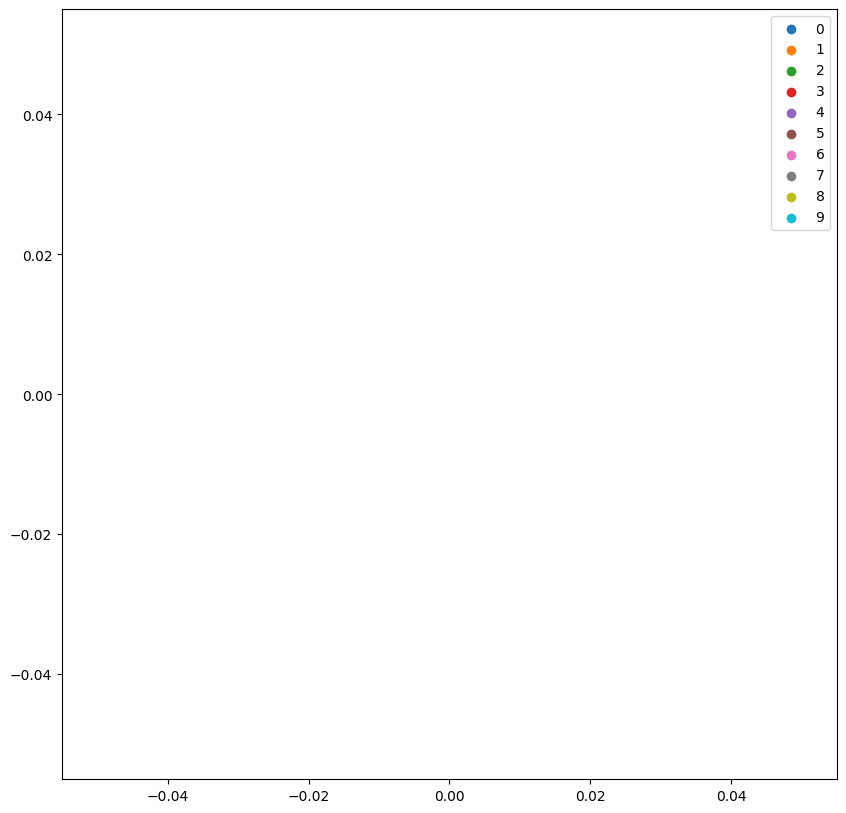

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Flatten the sparse_representations into a 2D array and create labels
flattened_representations = []
labels = []
for i in range(10):
    # Move each tensor in the list to CPU before extending flattened_representations
    flattened_representations.extend([tensor.cpu() for tensor in sparse_representations[i]])
    labels.extend([i] * len(sparse_representations[i]))

# Convert list to numpy array after the loop
flattened_representations = np.array(flattened_representations)

# Use TSNE to reduce dimensionality to 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
representations_2d = tsne.fit_transform(flattened_representations)

# Plot the results with different colors for each digit
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(representations_2d[labels == i, 0], representations_2d[labels == i, 1], label=str(i))
plt.legend()
plt.show()
print(flattened_representations)
print(labels)
print(representations_2d)